# Build RCNN and CNN with synthetic data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, ConvLSTM2D
from keras import optimizers

from box_gen import get_array_with_box_at_pos

Using TensorFlow backend.


In [2]:
# import data
data = joblib.load('sythetic_data.pkl')
X = np.asarray(data['X'])
y = np.asarray(data['y'])

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

X


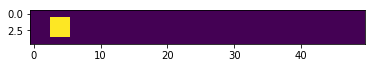

y 5.29711762656


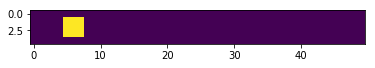

--
X


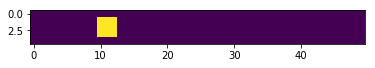

y 13.9199659398


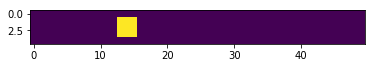

--
X


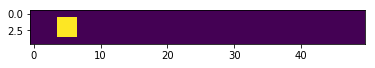

y 7.09820588302


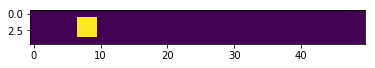

--
X


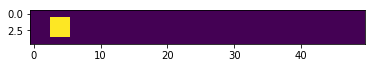

y 2.10122838336


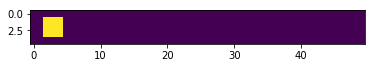

--
X


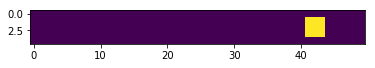

y 43.8586086805


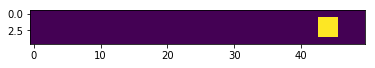

--


In [6]:
# print out x,y pairs
for frame, next_pos in zip(x_train[:5], y_train[:5]):
    print('X')
    plt.imshow(frame)
    plt.show()
    print('y', next_pos)
    plt.imshow(get_array_with_box_at_pos(next_pos))
    plt.show()
    print('--')

In [18]:
model = Sequential()

model.add(Conv2D(2, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(5, 50, 1), name='input'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, name='output'))

In [19]:
model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [100]:
def add_1(arr, front=False):
    if front:
        return arr.reshape([1,*arr.shape])
    
    return arr.reshape([*arr.shape,1])

In [21]:
model.fit(add_1(x_train), y_train,
          batch_size=10,
          epochs=200,
          verbose=0,
          validation_data=(add_1(x_test), add_1(y_test)))

In [22]:
print('Train', model.evaluate(add_1(x_train), y_train))

print('Test', model.evaluate(add_1(x_test), y_test))


69/69 [==============================] - 0s 54us/step
Train 8.38262577333
30/30 [==============================] - 0s 36us/step
Test 18.1734657288


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 3, 48, 2)          20        
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 48, 2)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                4624      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 4,661
Trainable params: 4,661
Non-trainable params: 0
_________________________________________________________________


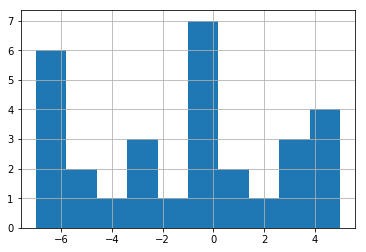

In [24]:
def get_hist_of_residuals(model, x, y):
    residual = model.predict(x) - y
    residuals = residual.astype(int).reshape([len(y)])
    pd.Series(residuals).hist()
    plt.show()
    
get_hist_of_residuals(model, add_1(x_test), add_1(y_test))

The plot above show how there are errors happening on both sides (predincting left when it should be right and vis-versa).

input


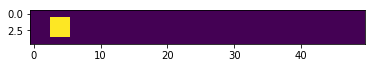

predict next frame


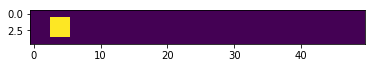

real next frame


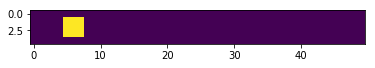

3.57118 --------

input


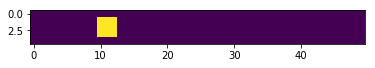

predict next frame


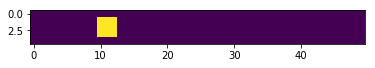

real next frame


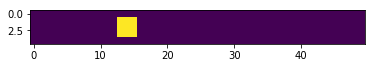

10.134 --------

input


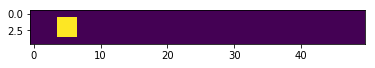

predict next frame


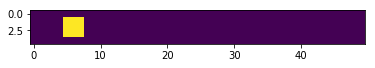

real next frame


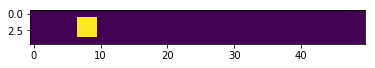

5.67475 --------

input


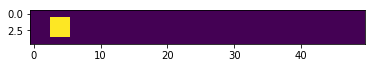

predict next frame


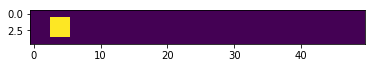

real next frame


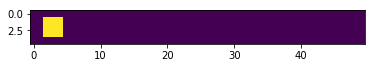

3.57118 --------

input


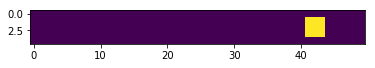

predict next frame


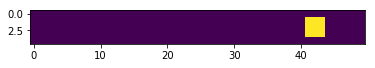

real next frame


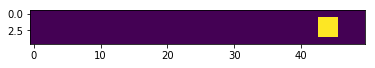

41.0307 --------



In [25]:
for frame, output in zip(x_train[:5], y_train[:5]):
    single_frame = add_1(frame.reshape([1,*frame.shape]))
    pred = model.predict(single_frame)[0][0]
    
    print('input')
    plt.imshow(frame)
    plt.show()
    
    print('predict next frame')
    plt.imshow(get_array_with_box_at_pos(pred))
    plt.show()
    
    print('real next frame')
    plt.imshow(get_array_with_box_at_pos(output))
    plt.show()
    print(pred, '--------\n')

# Test CNN with recurrent layer i.e R-CNN
Becuase we want to feed in teh previous 2 frames of information we need to restructure our training data.

https://keras.io/layers/recurrent/

## Re-structuure training data

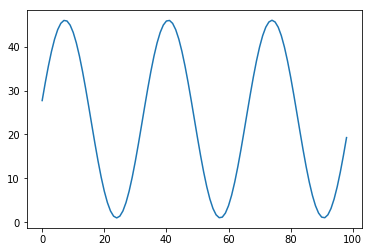

In [26]:
plt.plot(y)

In [27]:
chron_X = np.zeros([X.shape[0]-1, 2, X.shape[1], X.shape[2]])
chron_y = y[1:]

# stack the input frames in sequencial pairs
chron_X[:,0,:,:] = X[:-1]
chron_X[:,1,:,:] = X[1:]

chron_X.shape, chron_y.shape

((98, 2, 5, 50), (98,))

first input frame


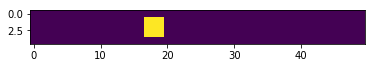

second input frame


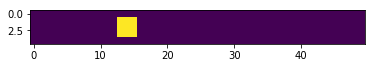

result y frame


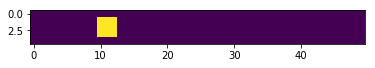

In [28]:
# look a input out for sanity

i = 18
print('first input frame')
plt.imshow(chron_X[i,0,:,:])
plt.show()

print('second input frame')
plt.imshow(chron_X[i,1,:,:])
plt.show()

print('result y frame')
plt.imshow(get_array_with_box_at_pos(chron_y[i]))
plt.show()


In [30]:
chron_X.shape, chron_y.shape

((98, 2, 5, 50), (98,))

In [31]:
# train-test split

split_point = int(len(chron_X)*0.7)

chron_x_train, chron_x_test = chron_X[:split_point], chron_X[split_point:]
chron_y_train, chron_y_test = chron_y[:split_point], chron_y[split_point:]

assert(len(chron_x_train) == len(chron_y_train))
assert(len(chron_x_test) == len(chron_y_test))

In [200]:
chron_model = Sequential()

chron_model.add(ConvLSTM2D(2, kernel_size=(3, 3), 
                 activation='relu',
                 input_shape=(2 ,5, 50, 1), name='input'))
chron_model.add(Dropout(0.5))
chron_model.add(Flatten())
chron_model.add(Dense(16, activation='relu'))
# chron_model.add(Dropout(0.1))
chron_model.add(Dense(1, name='output'))

In [201]:
chron_model.compile(loss='mean_absolute_percentage_error', optimizer='rmsprop')

In [217]:
chron_model.fit(add_1(chron_x_train), chron_y_train,
          batch_size=10,
          epochs=1000,
          verbose=0,
          validation_data=(add_1(chron_x_test), chron_y_test))

print('Train', chron_model.evaluate(add_1(chron_x_train), chron_y_train))

print('Test', chron_model.evaluate(add_1(chron_x_test), chron_y_test))

68/68 [==============================] - 0s 252us/step
Train 5.68495195052
30/30 [==============================] - 0s 230us/step
Test 8.50858879089


In [218]:
chron_x_test.shape

(30, 2, 5, 50)

In [219]:
chron_y_test.shape

(30,)

input


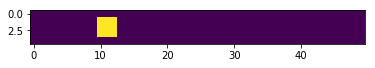

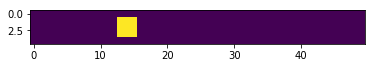

predict next frame


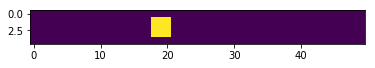

real next frame


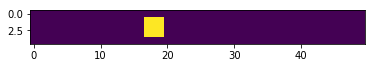

18.181 --------

input


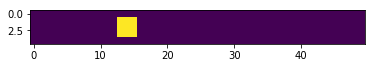

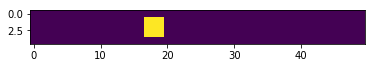

predict next frame


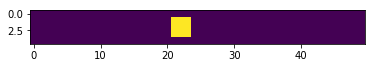

real next frame


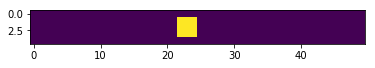

21.6149 --------

input


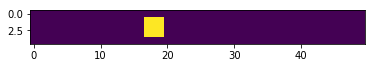

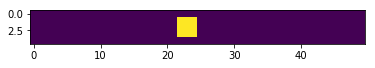

predict next frame


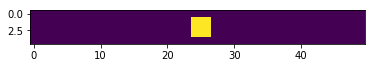

real next frame


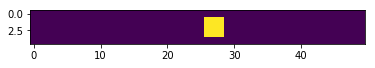

24.9482 --------

input


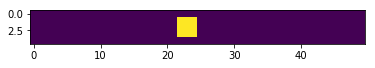

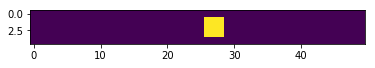

predict next frame


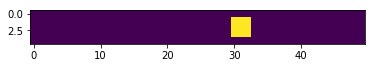

real next frame


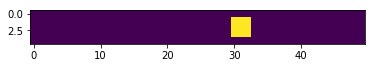

30.0582 --------

input


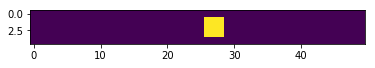

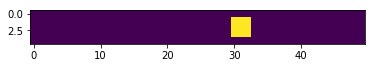

predict next frame


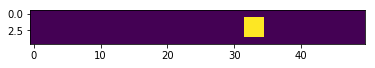

real next frame


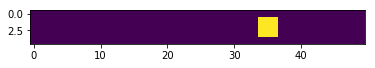

32.8293 --------

input


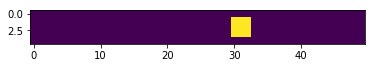

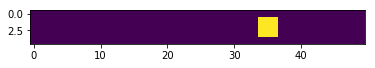

predict next frame


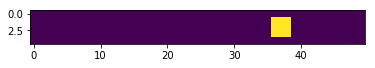

real next frame


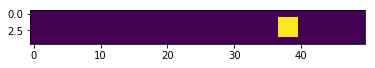

36.8176 --------

input


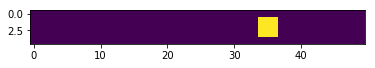

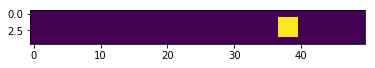

predict next frame


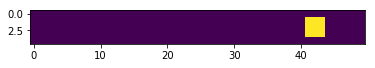

real next frame


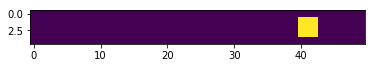

41.0285 --------

input


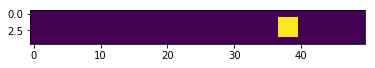

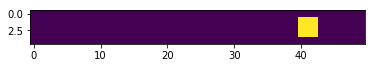

predict next frame


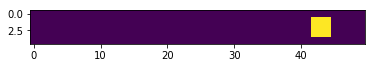

real next frame


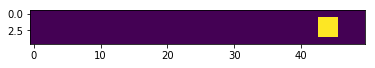

42.4444 --------

input


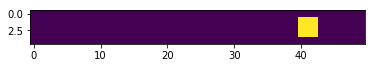

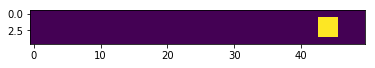

predict next frame


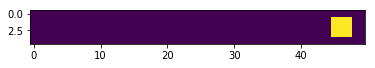

real next frame


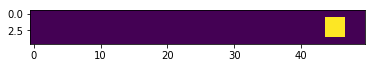

45.9438 --------

input


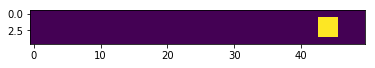

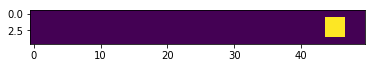

predict next frame


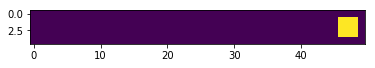

real next frame


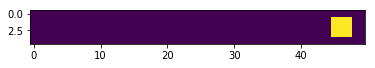

46.2619 --------



In [220]:
for frame, output in zip(chron_x_train[30:40], chron_y_train[30:40]):
    single_frame = add_1(frame.reshape([1,*frame.shape]))
    pred = chron_model.predict(single_frame)[0][0]
    
    print('input')
    plt.imshow(frame[0])
    plt.show()
    
    plt.imshow(frame[1])
    plt.show()
    
    print('predict next frame')
    plt.imshow(get_array_with_box_at_pos(pred))
    plt.show()
    
    print('real next frame')
    plt.imshow(get_array_with_box_at_pos(output))
    plt.show()
    print(pred, '--------\n')

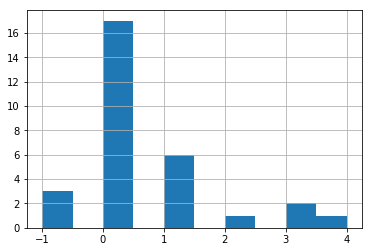

In [221]:
get_hist_of_residuals(chron_model, add_1(chron_x_test), add_1(chron_y_test))

# Let's test reversing frames to see if it's working

input


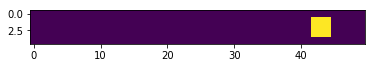

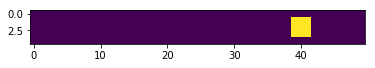

predict next frame


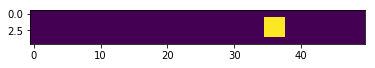

real next frame


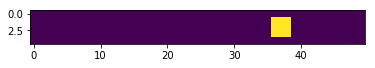

35.3033 --------



In [225]:
# first lets look at a frame and its prediction
    
frame = chron_x_test[10]
output = chron_y_test[10]

single_frame = add_1(frame.reshape([1,*frame.shape]))
pred = chron_model.predict(single_frame)[0][0]

print('input')
plt.imshow(frame[0])
plt.show()

plt.imshow(frame[1])
plt.show()

print('predict next frame')
plt.imshow(get_array_with_box_at_pos(pred))
plt.show()

print('real next frame')
plt.imshow(get_array_with_box_at_pos(output))
plt.show()
print(pred, '--------\n')

input (same frames as before but reversed)


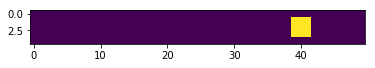

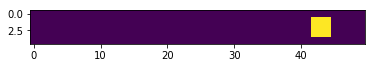

predict next frame


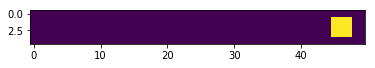

real next frame (ignore this as it's the old output before the frames were reversed)


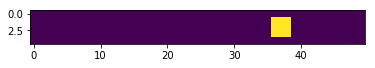

45.2521 --------



In [226]:
# now lets flip the input frames order

frame = chron_x_test[10]
output = chron_y_test[10]

# reverse the matrix along the time frame axis
frame = frame[::-1,:,:]

single_frame = add_1(frame.reshape([1,*frame.shape]))
pred = chron_model.predict(single_frame)[0][0]

print('input (same frames as before but reversed)')
plt.imshow(frame[0])
plt.show()

plt.imshow(frame[1])
plt.show()

print('predict next frame')
plt.imshow(get_array_with_box_at_pos(pred))
plt.show()

print('real next frame (ignore this as it\'s the old output before the frames were reversed)')
plt.imshow(get_array_with_box_at_pos(output))
plt.show()
print(pred, '--------\n')

## Awesome!!! It correctly understands time order when I reverse the frames
<img src="images/time.gif" style="width: 400px;"/>
